In [1]:
import os
import math
import six
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

tf.random.set_seed(1)

In [2]:
LIST_DIR = './data/VOCdevkit/VOC2012/ImageSets/Segmentation'
OUTPUT_DIR = "./data/VOCdevkit/tfrecord"

IMAGE_DIR = './data/VOCdevkit/VOC2012/JPEGImages'
IMAGE_FORMAT = 'jpg'

SEGMENTATION_DIR = "./data/VOCdevkit/VOC2012/SegmentationClass"
SEGMENTATION_FORMAT = 'png'

NUM_SHARDS = 6

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def img_seg_to_example(filename, image_data, seg_data):
    image_shape = tf.image.decode_jpeg(image_data).shape
    
    feature = {
        'image/encoded': _bytes_feature(image_data),
        'image/height': _int64_feature(image_shape[0]),
        'image/width': _int64_feature(image_shape[1]),
        'image/channels':  _int64_feature(image_shape[2]),
        'image/segmentation': (_bytes_feature(seg_data))
    }
    
    return tf.train.Example(features=tf.train.Features(feature=feature))

def convert_dataset(dataset_split):
    dataset = os.path.basename(dataset_split)[:-4]
    
    filenames = [x.strip('\n') for x in open(dataset_split, 'r')]
    num_images = len(filenames)
    
    print(f"Processing {dataset}: {num_images} Images")
    num_per_shard = int(math.ceil(num_images / NUM_SHARDS))
    
    for shard_id in range(NUM_SHARDS):
        output_filename = os.path.join(OUTPUT_DIR, '%s-%05d-of-%05d.tfrecord' % (dataset, shard_id, NUM_SHARDS))
        
        with tf.io.TFRecordWriter(output_filename) as writer:
            start_idx = shard_id * num_per_shard
            end_idx = min((shard_id + 1) * num_per_shard, num_images)
            
            for i in range(start_idx, end_idx):
                # READ IMAGE  
                image_filename = os.path.join(IMAGE_DIR, filenames[i] + '.' + IMAGE_FORMAT)
                image_data = tf.io.gfile.GFile(image_filename, 'rb').read()

                # READ SEGMENTATION
                seg_filename = os.path.join(SEGMENTATION_DIR, filenames[i] + '.' + SEGMENTATION_FORMAT)
                seg_data = tf.io.gfile.GFile(seg_filename, mode='rb').read()
                
                # CREATE TFRECORD EXAMPLE
                example = img_seg_to_example(filenames[i], image_data, seg_data)

                # WRITE TO DISK
                writer.write(example.SerializeToString())
            
dataset_splits = tf.io.gfile.glob(os.path.join(LIST_DIR, "*.txt"))
for dataset_split in dataset_splits:
    convert_dataset(dataset_split)

Processing train: 1464 Images
Processing val: 1449 Images


In [3]:
IMG_DIM = 256
BATCH_SIZE = 32
BUFFER_SIZE = 500
N_CLASSES = 64

def normalize(input_image, input_mask):
    input_image = tf.image.per_image_standardization(input_image)
    return input_image, input_mask

def parse_image(content, channels):
    return tf.cond(
        tf.image.is_jpeg(content), 
        lambda: tf.image.decode_jpeg(content, channels), 
        lambda: tf.image.decode_png(content, channels)
    )
    
def parse_dataset(example_proto):
    features = {
        'image/encoded':
            tf.io.FixedLenFeature((), tf.string, default_value=''),
        'image/height':
            tf.io.FixedLenFeature((), tf.int64, default_value=0),
        'image/width':
            tf.io.FixedLenFeature((), tf.int64, default_value=0),
        'image/segmentation':
            tf.io.FixedLenFeature((), tf.string, default_value=''),
    }
    
    parsed_feature = tf.io.parse_single_example(example_proto, features)
    
    image = parse_image(parsed_feature['image/encoded'], channels=3)
    image = tf.image.resize(image, (IMG_DIM, IMG_DIM))
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    label = parse_image(parsed_feature['image/segmentation'], channels=1)
    label = tf.image.resize(label, (IMG_DIM, IMG_DIM))
    
    return image, label

train_list_ds = tf.data.Dataset.list_files(OUTPUT_DIR + "/train-*.tfrecord")
valid_list_ds = tf.data.Dataset.list_files(OUTPUT_DIR + "/val-*.tfrecord")


train_ds = (tf.data
    .TFRecordDataset(train_list_ds)
    .map(parse_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE))

valid_ds = (tf.data
    .TFRecordDataset(valid_list_ds)
    .map(parse_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE))

W0519 10:49:54.723933 140736103531392 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/image_ops_impl.py:1518: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [4]:
def conv_block(layer_size, input_data, filters, kernel_size = 3, dilation_rate=1, padding = 'same', pool = False, name = ''):
    if dilation_rate == 1:
        conv_type = 'conv'
    else:
        conv_type = 'dilated_conv'
    
    for i in range(1, layer_size + 1):
        input_data = (keras.layers.Conv2D(
                filters=filters, 
                kernel_size=kernel_size, 
                dilation_rate=dilation_rate,
                padding=padding,
                name=f'block_{conv_type}_{name}_{i}', 
                use_bias=True))(input_data)
        input_data = keras.layers.Activation('relu', name=f'relu_{name}_{i}')(input_data)
        
    if pool:
        input_data = keras.layers.MaxPool2D(2, name=f'max_pool_{name}')(input_data)
    
    return input_data
  
def bilinear_upsample(sample):
    image_size = sample[1]
    upsampled = tf.image.resize(sample[0], size=(image_size[0], image_size[1]), method='bilinear')
    return upsampled
    
def build_network(input_shape, nclasses, use_ctx = False):
    inputs = keras.layers.Input(input_shape)
    x = conv_block(layer_size=2, input_data=inputs, kernel_size=3, filters=N_CLASSES, pool=True, name=1)
    x = conv_block(layer_size=2, input_data=x, kernel_size=3, filters=N_CLASSES * 2, pool=True, name=2)
    x = conv_block(layer_size=3, input_data=x, kernel_size=3, filters=N_CLASSES * 4, pool=True, name=3)
    x = conv_block(layer_size=3, input_data=x, kernel_size=3, filters=N_CLASSES * 8, pool=False, name=4)
    x = conv_block(layer_size=3, input_data=x, kernel_size=3, filters=N_CLASSES * 8, dilation_rate=2, pool=False, name=5)
    
    x = conv_block(layer_size=1, input_data=x, kernel_size=7, filters=4096, dilation_rate=4, name='_FCN1')
    x = keras.layers.Dropout(0.5)(x)
    x = conv_block(layer_size=1, input_data=x, kernel_size=7, filters=4096, name='_FCN2')
    x = keras.layers.Dropout(0.5)(x)
    
    if use_ctx:
        x = conv_block(layer_size=2, input_data=x, filters=N_CLASSES * 2, kernel_size=3, name='_ctx1')
        x = conv_block(layer_size=1, input_data=x, filters=N_CLASSES * 4, kernel_size=3, name='_ctx2', dilation_rate=2)
        x = conv_block(layer_size=1, input_data=x, filters=N_CLASSES * 8, kernel_size=3, name='_ctx3', dilation_rate=4)
        x = conv_block(layer_size=1, input_data=x, filters=N_CLASSES * 16, kernel_size=3, name='_ctx4', dilation_rate=8)
        x = conv_block(layer_size=1, input_data=x, filters=N_CLASSES * 32, kernel_size=3, name='_ctx5', dilation_rate=16)
        x = conv_block(layer_size=1, input_data=x, filters=N_CLASSES * 32, kernel_size=3, name='_ctx6')
        x = keras.layers.Conv2D(filters=nclasses, kernel_size=1, padding='same', name='ctx_output')(x)
    
    x = keras.layers.Lambda(bilinear_upsample, name='bilinear_upsample')([x, input_shape])
    x = keras.layers.Softmax()(x)
    
    return keras.Model(inputs, x)

In [5]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

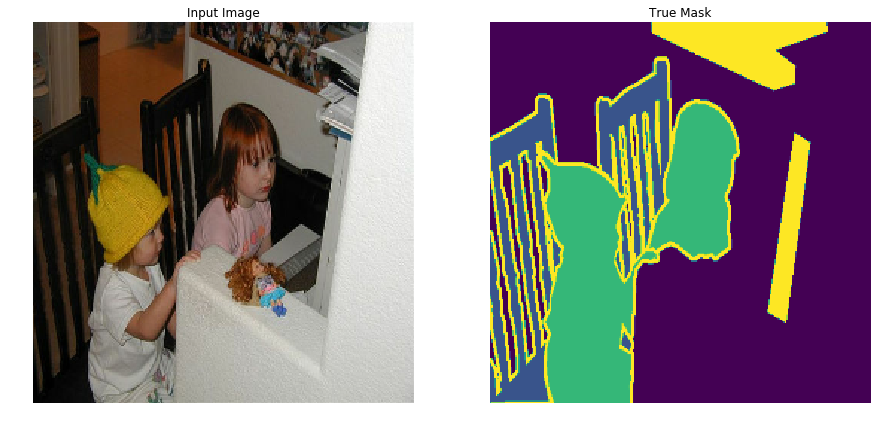

In [6]:
for image, mask in train_ds.take(1):
    sample_image, sample_mask = image[3], mask[3]
display([sample_image, sample_mask])

In [7]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [8]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 1800//BATCH_SIZE//VAL_SUBSPLITS

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = build_network((IMG_DIM, IMG_DIM, 3), 21, use_ctx=True)
    model.compile(optimizer='adam',
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    model_history = model.fit(train_ds, epochs=EPOCHS,
                            steps_per_epoch=(1800 // BATCH_SIZE),
                            validation_steps=VALIDATION_STEPS,
                            validation_data=valid_ds,
                            callbacks=[DisplayCallback()])

W0519 10:49:56.218837 140736103531392 cross_device_ops.py:1209] There is non-GPU devices in `tf.distribute.Strategy`, not using nccl allreduce.


Train for 56 steps, validate for 11 steps
Epoch 1/50
